In [2]:
import pandas as pd

air_reserve = pd.read_csv('./data/air_reserve.csv', parse_dates=['visit_datetime', 'reserve_datetime'])
air_store_info = pd.read_csv('./data/air_store_info.csv')
air_visit_data = pd.read_csv('./data/air_visit_data.csv', parse_dates=['visit_date'])
hpg_reserve = pd.read_csv('./data/hpg_reserve.csv', parse_dates=['visit_datetime', 'reserve_datetime'])
hpg_store_info = pd.read_csv('./data/hpg_store_info.csv')
date_info = pd.read_csv('./data/date_info.csv', parse_dates=['calendar_date'])
store_id_relation = pd.read_csv('./data/store_id_relation.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

* 829 air stores
* 92,378 air reservations
* 252,108 day visit records for air stores
* 4,690 hpg stores
* 2,000,320 hpg reservations
* No data on actual visits for hpg
* 150 air stores can be joined to hpg stores
* We need to predict visitors for 821 air stores on 39 dates
* All except 8 air stores are in the test set
* air_store_info covers all air stores
* Series differ between stores - different time periods
* Some stores have quire irregular work schedule
* There are lots of days missing, some stores have 477 days of data, while others only 20
* Visit data isn't equal to reservation data

In [29]:
test_stores = (sample_submission['id'].apply(lambda i: i[:20]).unique())
test_dates = (sample_submission['id'].apply(lambda i: i[20:]).unique())

In [3]:
set(air_visit_data['air_store_id']) - set(test_stores)

{'air_0ead98dd07e7a82a',
 'air_229d7e508d9f1b5e',
 'air_2703dcb33192b181',
 'air_b2d8bc9c88b85f96',
 'air_cb083b4789a8d3a2',
 'air_cf22e368c1a71d53',
 'air_d0a7bd3339c3d12a',
 'air_d63cfa6d6ab78446'}

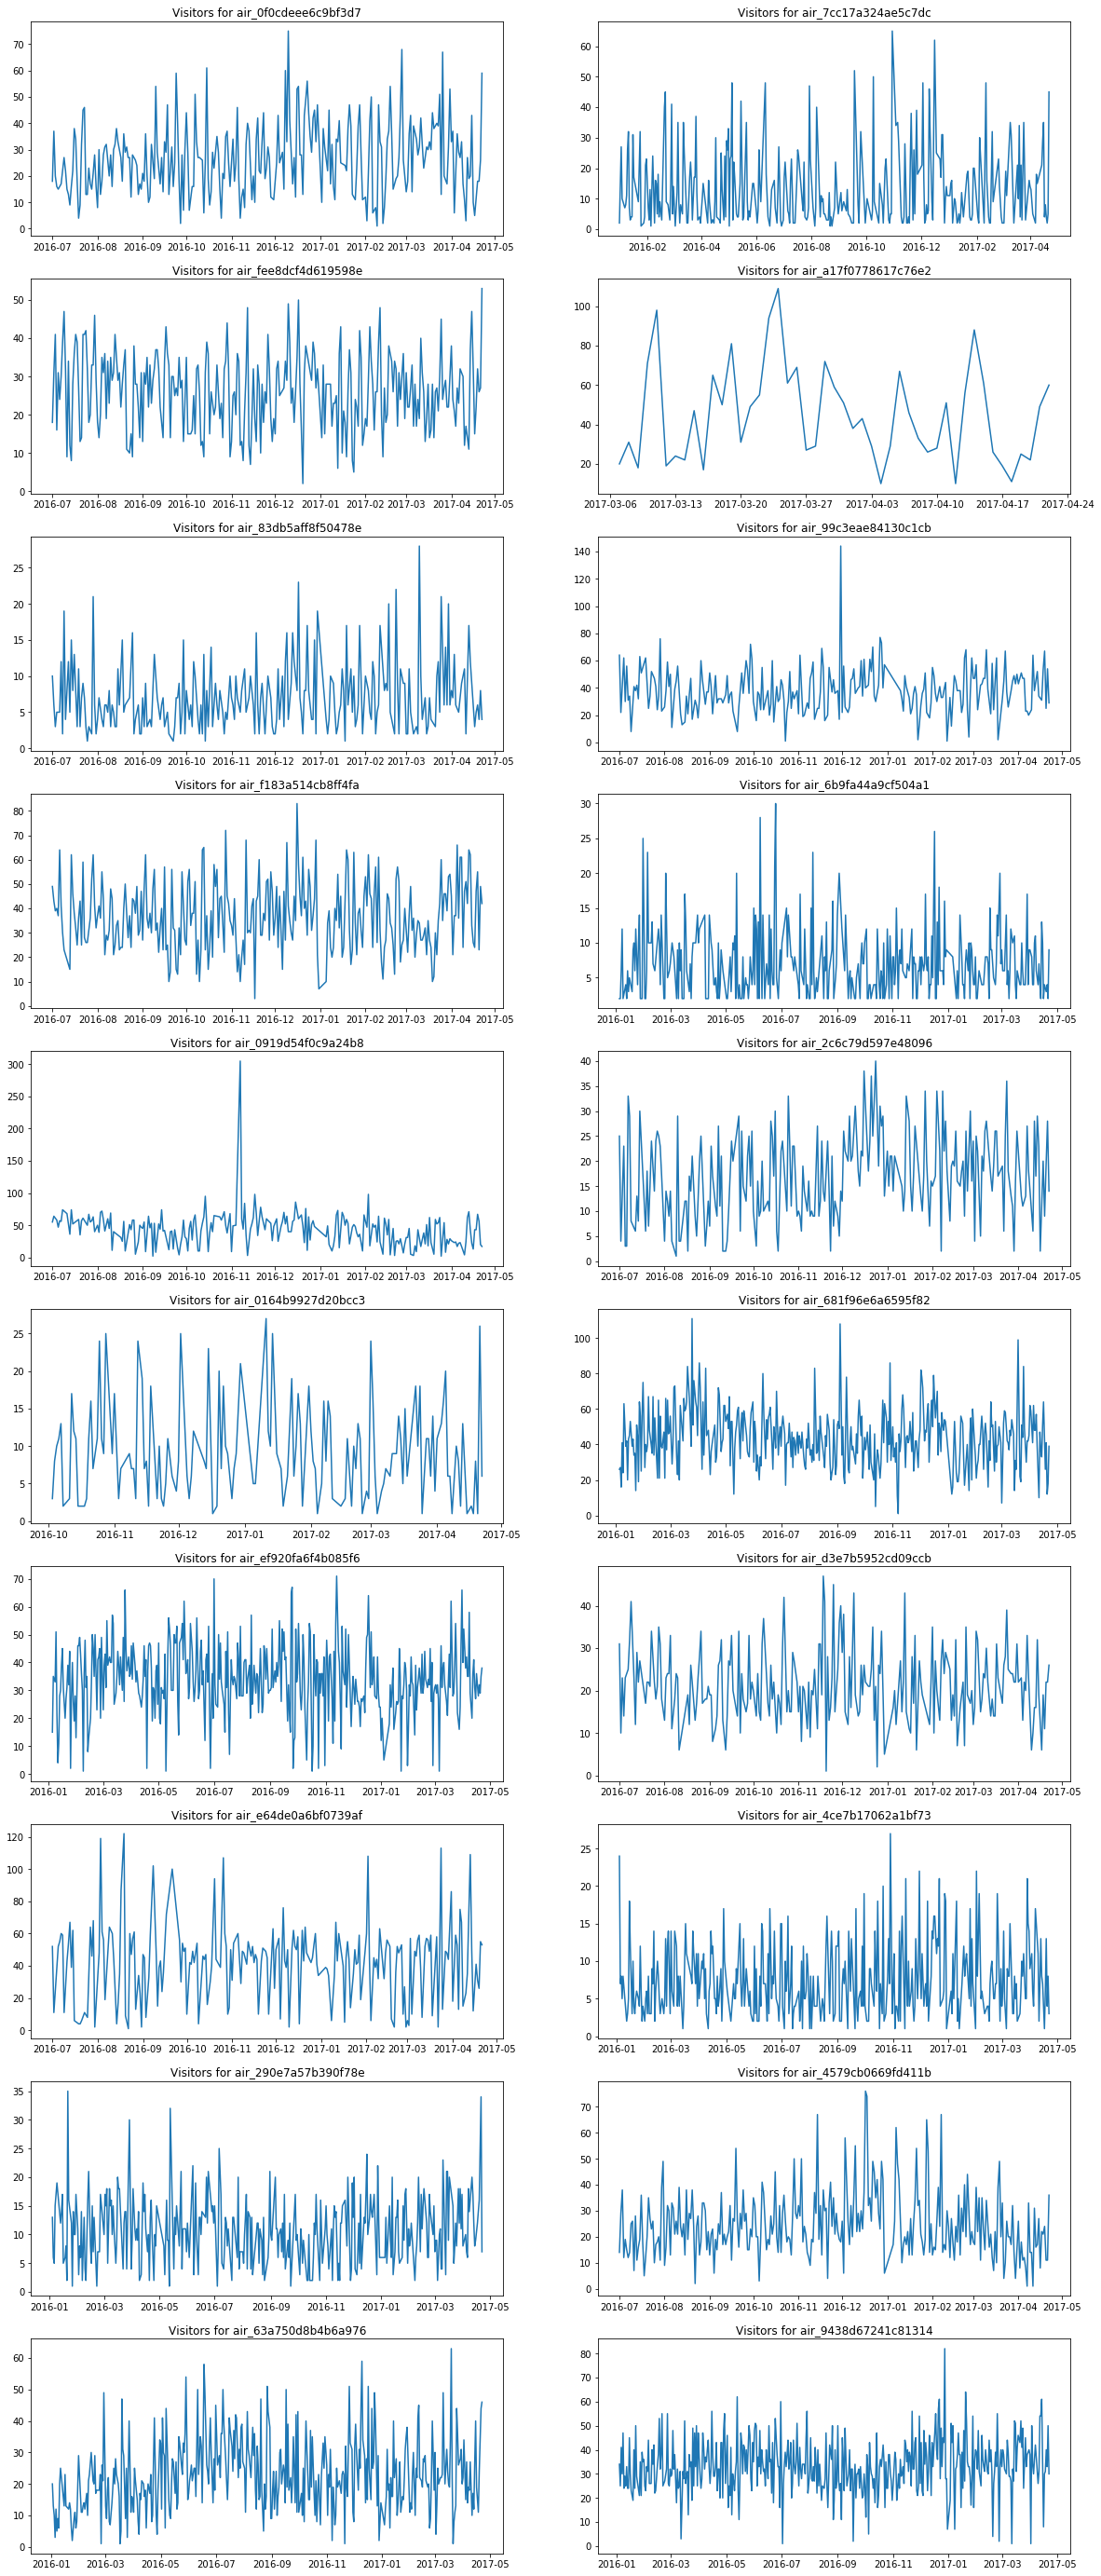

In [18]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
max_stores = 20
plt.figure(figsize=(20, max_stores * 5 / 2))
for i, store in enumerate(air_store_info.head(max_stores).air_store_id):
    visit_data = air_visit_data[air_visit_data.air_store_id == store]
    visit_data = visit_data.sort_values(by='visit_date')
    visit_data = visit_data.drop('air_store_id', axis=1)
    visit_data = visit_data.set_index('visit_date')
    plt.subplot(max_stores / 2, 2, i + 1)
    plt.plot(visit_data.visitors)
    plt.title('Visitors for ' + store)

In [26]:
columns = {
    'id': [],
    'from': [],
    'to': [],
    'count': []
}

for store in air_store_info.air_store_id:
    visit_data = air_visit_data[air_visit_data.air_store_id == store]
    columns['id'].append(store)
    columns['from'].append(visit_data.visit_date.min())
    columns['to'].append(visit_data.visit_date.max())
    columns['count'].append(len(visit_data))
stats = pd.DataFrame(columns)

In [34]:
stats[stats.id.isin(test_stores)].sort_values(by='count')

,count,from,id,to
46,20,2017-03-02,air_900d755ebd2f7bbd,2017-04-22
270,40,2016-07-02,air_a9a380530c1e121f,2017-04-22
572,41,2016-07-06,air_789103bf53b8096b,2017-04-22
3,47,2017-03-07,air_a17f0778617c76e2,2017-04-22
618,51,2017-03-02,air_1c0b150f9e696a5f,2017-04-22
224,53,2017-02-15,air_cf5ab75a0afb8af9,2017-04-22
43,54,2016-07-03,air_8e492076a1179383,2017-04-19
298,62,2017-02-08,air_8e8f42f047537154,2017-04-22
759,66,2017-02-09,air_bb4ff06cd661ee9b,2017-04-22
574,69,2017-01-24,air_8110d68cc869b85e,2017-04-22


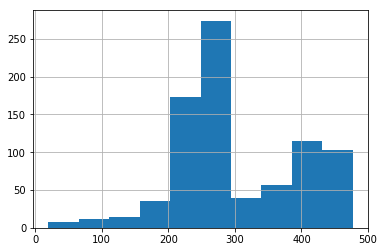

In [32]:
stats['count'].hist()

In [52]:
air_reserve['visit_date'] = air_reserve.visit_datetime.apply(lambda d: d.date())

In [74]:
gr = air_reserve.groupby(['air_store_id', 'visit_date'])
gr = gr.agg({ 'reserve_visitors': 'sum' })
gr

reserve_visitors
air_store_id         visit_date                  
air_00a91d42b08b08d9 2016-10-31                 2
                     2016-12-05                 9
                     2016-12-14                18
                     2016-12-17                 2
                     2016-12-20                 4
                     2017-02-18                 9
                     2017-02-23                12
                     2017-03-01                 3
                     2017-03-14                 4
                     2017-03-21                 3
                     2017-03-24                 2
                     2017-04-04                 2
air_0164b9927d20bcc3 2016-10-28                12
                     2016-11-01                10
                     2016-11-02                 3
                     2016-11-08                 9
                     2016-11-10                 6
                     2016-11-11                 4
                     2016-11-14                17
                     2016-11-15                 3
                     2016-11-16                 2
                     2016-11-18                13
                     2016-11-21                 3
                     2016-11-22                 9
                     2016-11-24                 2
                     2016-11-26                10
                     2016-11-28                 2
                     2016-12-02                 3
                     2016-12-05                 4
                     2016-12-06                 2
...                                           ...
air_fea5dc9594450608 2017-03-08                 2
                     2017-03-10                 3
                     2017-03-11                 7
                     2017-03-16                 3
                     2017-03-17                11
                     2017-03-18                10
                     2017-03-21                 5
                     2017-03-22                 2
                     2017-03-23                 8
                     2017-03-24                 2
                     2017-03-25                 6
                     2017-03-29                 2
                     2017-03-30                 5
                     2017-04-01                 2
                     2017-04-05                 4
                     2017-04-07                 2
                     2017-04-08                 5
                     2017-04-11                 4
                     2017-04-12                 2
                     2017-04-14                 2
                     2017-04-15                 4
                     2017-04-18                 2
                     2017-04-19                 2
                     2017-04-20                 6
                     2017-04-21                10
                     2017-04-22                 2
                     2017-04-25                 2
                     2017-04-28                 3
                     2017-05-20                 6
air_fee8dcf4d619598e 2017-01-09                 5

[29830 rows x 1 columns]

In [75]:
air_visit_data[air_visit_data.air_store_id == 'air_0164b9927d20bcc3']

,air_store_id,visit_date,visitors
89482,air_0164b9927d20bcc3,2016-10-03,3
89483,air_0164b9927d20bcc3,2016-10-04,8
89484,air_0164b9927d20bcc3,2016-10-05,10
89485,air_0164b9927d20bcc3,2016-10-06,11
89486,air_0164b9927d20bcc3,2016-10-07,13
89487,air_0164b9927d20bcc3,2016-10-08,2
89488,air_0164b9927d20bcc3,2016-10-11,3
89489,air_0164b9927d20bcc3,2016-10-12,17
89490,air_0164b9927d20bcc3,2016-10-13,12
89491,air_0164b9927d20bcc3,2016-10-14,11
